**AVISO: Este é o segundo módulo e deve utilizar o kernel do LeituraFicheiros_PBD-grupo12.ipynb**

# Feature Engineering

Nesta fase/ficheiro será feita a limpeza dos dados e transformação de features para prever se os jogadores respondem às respostas corretamente, numa fase posterior do projeto. 

Por esse meio, continuamos a seguir a *pipeline* de ML na componente de **Feature Engineering**, tal como visualizado abaixo.

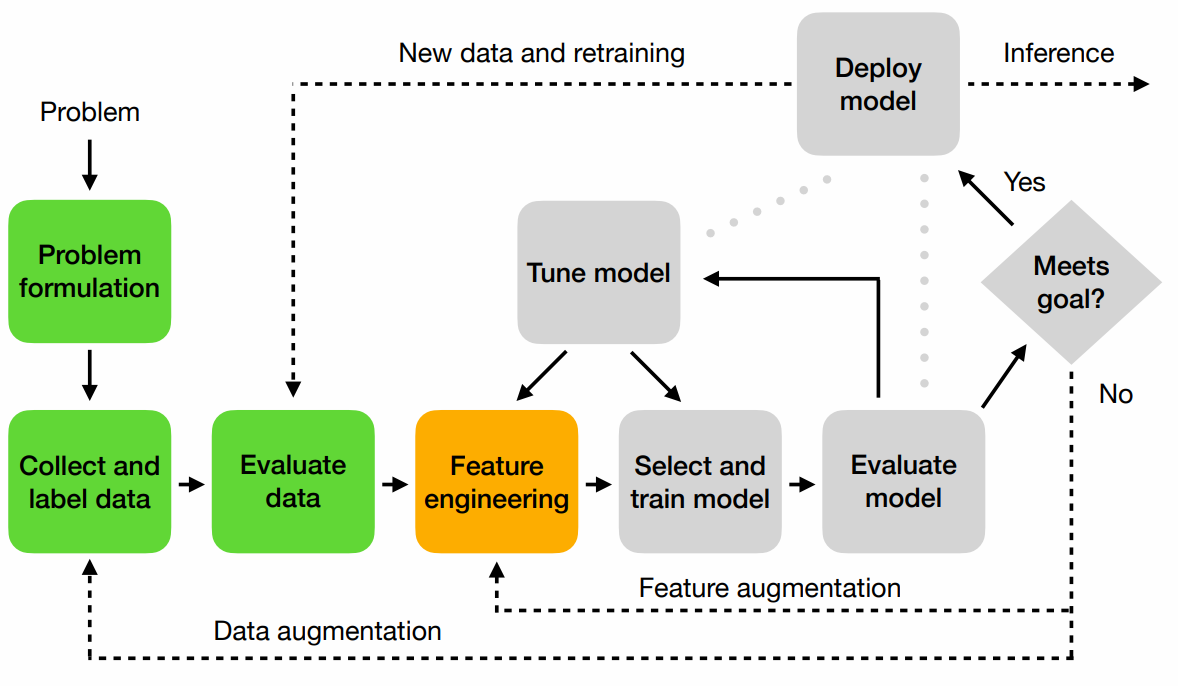

## Tratamento da base de dados dos jogos

Visualizando os resultados da leitura de ficheiros, optámos por deixar em separado (para apagar ou não depois) as colunas "page", "hover_duration", "text" e "text_fqid", pois todos possuem mais de 50% de dados omissos. Estas colunas têm mais de 50 % dos omissos devido ao facto de corresponderem a alguma interação específica.

Colunas do dataset, optando por não retirar as colunas para já.

In [25]:
jogos.columns

['session_id',
 'index',
 'elapsed_time',
 'event_name',
 'name',
 'level',
 'page',
 'room_coor_x',
 'room_coor_y',
 'screen_coor_x',
 'screen_coor_y',
 'hover_duration',
 'text',
 'fqid',
 'room_fqid',
 'text_fqid',
 'fullscreen',
 'hq',
 'music',
 'level_group']

Lista de todos os nomes de evento diferentes, para análise.

In [26]:
jogos.select("event_name").distinct().show()

+------------------+
|        event_name|
+------------------+
|    navigate_click|
|      object_click|
|    notebook_click|
| observation_click|
|    cutscene_click|
|        checkpoint|
|notification_click|
|      person_click|
|         map_hover|
|         map_click|
|      object_hover|
+------------------+



### Transformação dos dados de clique por agrupamento

Devido à elevada extensão dos dados, decidiu-se agrupar os dados de cliques, correspondentes a cada linha da base de dados, por `session_id` e por `level_group`. Isto foi feito com o intuito de reduzir o tamanho dos dados mas, sobretudo, para conseguir agrupar o dataset de labels que tem as respostas dadas às 18 perguntas.

No agrupamento, as colunas tiveram de ser tomadas ou pelo valor da média (`screen_coor_x`,`screen_coor_y`,`room_coor_x`,`room_coor_x`,`fullscreen`,`hq`,`music`), ou da soma de valores da coluna (`elapsed_time`,`hover_duration`). Ainda, foram criadas novas features para o `event_name`, que conta o número de cada um dos eventos em cada agrupamento, e mais três que o seu significado constam na tabela abaixo.

Novas Features | descrição breve 
:-:|-
`TextCountDistinct` | Conta o número de mensagens de texto diferentes que aparece, por sessão, em cada grupo de níveis
`ComprimentoTexto` | Conta o comprimento total do texto que aparece, por sessão, em cada grupo de níveis
`NumeroEventos` | Número total de eventos que ocorrem, por sessão, em cada grupo de níveis

In [27]:
jogos_bigData = (jogos
 .select("*")
 .groupBy("session_id", "level_group")
 .agg((F.mean("screen_coor_x").alias("mean_screen_coor_x")), 
      (F.mean("screen_coor_y").alias("mean_screen_coor_y")), 
      (F.mean("room_coor_x").alias("mean_room_coor_x")),
      (F.mean("room_coor_y").alias("mean_room_coor_y")),
      F.mean(F.when(jogos.fullscreen != 0, jogos.fullscreen).otherwise(0)).alias("fullscreen"),
      F.mean(F.when(jogos.hq != 0, jogos.hq).otherwise(0)).alias("hq"),
      F.mean(F.when(jogos.music != 0, jogos.music).otherwise(0)).alias("music"),
      (F.max("elapsed_time")/1000).alias("elapsed_time/sec"),
      (F.countDistinct("text")).alias("TextCountDistinct"),
      (F.sum(F.when(F.col("event_name")=="navigate_click", 1).otherwise(0))).alias("navigate_click"),
      (F.sum(F.when(F.col("event_name")=="object_click", 1).otherwise(0))).alias("object_click"),
      (F.sum(F.when(F.col("event_name")=="notebook_click", 1).otherwise(0))).alias("notebook_click"),
      (F.sum(F.when(F.col("event_name")=="observation_click", 1).otherwise(0))).alias("observation_click"),
      (F.sum(F.when(F.col("event_name")=="cutscene_click", 1).otherwise(0))).alias("cutscene_click"),
      (F.sum(F.when(F.col("event_name")=="notification_click", 1).otherwise(0))).alias("notification_click"),
      (F.sum(F.when(F.col("event_name")=="person_click", 1).otherwise(0))).alias("person_click"),
      (F.sum(F.when(F.col("event_name")=="map_hover", 1).otherwise(0))).alias("map_hover"),
      (F.sum(F.when(F.col("event_name")=="map_click", 1).otherwise(0))).alias("map_click"),
      (F.sum(F.when(F.col("event_name")=="checkpoint", 1).otherwise(0))).alias("checkpoint"),
      (F.sum(F.when(F.col("event_name")=="object_hover", 1).otherwise(0))).alias("object_hover"),
      (F.sum(F.when(F.col("hover_duration").isNotNull(), F.col("hover_duration")).otherwise(0))).alias("hover_duration"),
      (F.sum(F.when(F.col("text").isNotNull(), F.length(F.col("text"))).otherwise(0))).alias("ComprimentoTexto"),
      (F.max("index")).alias("NumeroEventos")))

Filtrar por um id para ver se ficou corretamente agrupado.

In [28]:
jogos_bigData.filter(F.col("session_id")==20110310350354548).show(vertical=True)

-RECORD 0---------------------------------
 session_id         | 20110310350354548   
 level_group        | 13-22               
 mean_screen_coor_x | 443.5078534031414   
 mean_screen_coor_y | 356.29842931937173  
 mean_room_coor_x   | -110.87690783438616 
 mean_room_coor_y   | -120.45645293686295 
 fullscreen         | 1.0                 
 hq                 | 1.0                 
 music              | 1.0                 
 elapsed_time/sec   | 1856.087            
 TextCountDistinct  | 168                 
 navigate_click     | 141                 
 object_click       | 30                  
 notebook_click     | 20                  
 observation_click  | 4                   
 cutscene_click     | 60                  
 notification_click | 9                   
 person_click       | 112                 
 map_hover          | 16                  
 map_click          | 6                   
 checkpoint         | 1                   
 object_hover       | 21                  
 hover_dura

Conseguimos observar que o `level_group` de *0-4* é o menor nível, pois tem um número de eventos e de distribuição de cliques menor, tal como seria expectável dado que é o grupo de níveis mais pequeno e com menos perguntas.

Ainda, é possivel reparar que existem dados que possuem `level_group` nulos, sendo que estes correspondem ao `checkpoint`, então o grupo optou por eliminar os nulos e a coluna do checkpoint.

In [29]:
jogos_bigData = jogos_bigData.na.drop()
jogos_bigData = jogos_bigData.drop("checkpoint")

In [30]:
jogos_bigData.filter(F.col("session_id")==20110310350354548).show(vertical=True)

-RECORD 0---------------------------------
 session_id         | 20110310350354548   
 level_group        | 13-22               
 mean_screen_coor_x | 443.5078534031414   
 mean_screen_coor_y | 356.29842931937173  
 mean_room_coor_x   | -110.87690783438616 
 mean_room_coor_y   | -120.45645293686295 
 fullscreen         | 1.0                 
 hq                 | 1.0                 
 music              | 1.0                 
 elapsed_time/sec   | 1856.087            
 TextCountDistinct  | 168                 
 navigate_click     | 141                 
 object_click       | 30                  
 notebook_click     | 20                  
 observation_click  | 4                   
 cutscene_click     | 60                  
 notification_click | 9                   
 person_click       | 112                 
 map_hover          | 16                  
 map_click          | 6                   
 object_hover       | 21                  
 hover_duration     | 66011.0             
 Compriment

Verificamos o tipo de dados do dataset.

In [31]:
jogos_bigData

DataFrame[session_id: bigint, level_group: string, mean_screen_coor_x: double, mean_screen_coor_y: double, mean_room_coor_x: double, mean_room_coor_y: double, fullscreen: double, hq: double, music: double, elapsed_time/sec: double, TextCountDistinct: bigint, navigate_click: bigint, object_click: bigint, notebook_click: bigint, observation_click: bigint, cutscene_click: bigint, notification_click: bigint, person_click: bigint, map_hover: bigint, map_click: bigint, object_hover: bigint, hover_duration: double, ComprimentoTexto: bigint, NumeroEventos: int]

## Labels

Vamos ler e verificar o ficheiro de respostas corretas para juntar ao ficheiro de dados agrupado acima.

In [32]:
# leitura do ficheiro treino, com o schema predefinido
filename = "train_labels.csv"
labels = spark.read.csv(filename, header=True, inferSchema=True, sep=",")

In [33]:
labels.show()

+--------------------+-------+
|          session_id|correct|
+--------------------+-------+
|20090312431273200_q1|      1|
|20090312433251036_q1|      0|
|20090312455206810_q1|      1|
|20090313091715820_q1|      0|
|20090313571836404_q1|      1|
|20090314035813970_q1|      1|
|20090314121766812_q1|      1|
|20090314221187252_q1|      0|
|20090314363702160_q1|      1|
|20090314441803444_q1|      1|
|20090315081004164_q1|      0|
|20090315085850788_q1|      1|
|20090315101457836_q1|      1|
|20090315170769824_q1|      1|
|20090315270479452_q1|      0|
|20090316152177500_q1|      1|
|20090316190523732_q1|      1|
|20090317080721164_q1|      0|
|20090317111400710_q1|      1|
|20090317414400068_q1|      1|
+--------------------+-------+
only showing top 20 rows



Como as questões e o id da sessão encontram-se no mesmo campo (`session_id`), iremos separar para tornar mais fácil de visualizar e agrupar.

In [34]:
labels = labels.withColumn(
            "question", F.split("session_id", "_q").getItem(1))
labels = labels.withColumn(
            "question", F.col("question").cast(IntegerType()))
labels.show()

+--------------------+-------+--------+
|          session_id|correct|question|
+--------------------+-------+--------+
|20090312431273200_q1|      1|       1|
|20090312433251036_q1|      0|       1|
|20090312455206810_q1|      1|       1|
|20090313091715820_q1|      0|       1|
|20090313571836404_q1|      1|       1|
|20090314035813970_q1|      1|       1|
|20090314121766812_q1|      1|       1|
|20090314221187252_q1|      0|       1|
|20090314363702160_q1|      1|       1|
|20090314441803444_q1|      1|       1|
|20090315081004164_q1|      0|       1|
|20090315085850788_q1|      1|       1|
|20090315101457836_q1|      1|       1|
|20090315170769824_q1|      1|       1|
|20090315270479452_q1|      0|       1|
|20090316152177500_q1|      1|       1|
|20090316190523732_q1|      1|       1|
|20090317080721164_q1|      0|       1|
|20090317111400710_q1|      1|       1|
|20090317414400068_q1|      1|       1|
+--------------------+-------+--------+
only showing top 20 rows



Alterar o nome da coluna criada

In [35]:
# Mudar o nome da coluna
labels=labels.withColumnRenamed("session_id", "session_id2")

Para cada questão, serão associados o `level_group` a que a questão pertence. Foi adotado que as primeiras 4 questões estão no grupo de 0-4, as 9 seguintes no grupo de questões de 5-12 e que as restantes 5 questões estão no grupo de 13-22.

In [36]:
def generateLevelgroup(x):
    if x<=3:
        return "0-4"
    elif x<=13:
        return "5-12"
    else:
        return "13-22"
    
my_udf = F.udf(generateLevelgroup, StringType())
labels = labels.withColumn("level_group", my_udf("question"))
labels.show()

+--------------------+-------+--------+-----------+
|         session_id2|correct|question|level_group|
+--------------------+-------+--------+-----------+
|20090312431273200_q1|      1|       1|        0-4|
|20090312433251036_q1|      0|       1|        0-4|
|20090312455206810_q1|      1|       1|        0-4|
|20090313091715820_q1|      0|       1|        0-4|
|20090313571836404_q1|      1|       1|        0-4|
|20090314035813970_q1|      1|       1|        0-4|
|20090314121766812_q1|      1|       1|        0-4|
|20090314221187252_q1|      0|       1|        0-4|
|20090314363702160_q1|      1|       1|        0-4|
|20090314441803444_q1|      1|       1|        0-4|
|20090315081004164_q1|      0|       1|        0-4|
|20090315085850788_q1|      1|       1|        0-4|
|20090315101457836_q1|      1|       1|        0-4|
|20090315170769824_q1|      1|       1|        0-4|
|20090315270479452_q1|      0|       1|        0-4|
|20090316152177500_q1|      1|       1|        0-4|
|20090316190

Criação de uma coluna só com o `session_id`, sem o número da questão à frente.

In [37]:
labels = labels.withColumn(
            "session_id", F.split("session_id2", "_q").getItem(0))
labels = labels.withColumn(
            "session_id", F.col("session_id").cast(LongType()))
labels.show()

+--------------------+-------+--------+-----------+-----------------+
|         session_id2|correct|question|level_group|       session_id|
+--------------------+-------+--------+-----------+-----------------+
|20090312431273200_q1|      1|       1|        0-4|20090312431273200|
|20090312433251036_q1|      0|       1|        0-4|20090312433251036|
|20090312455206810_q1|      1|       1|        0-4|20090312455206810|
|20090313091715820_q1|      0|       1|        0-4|20090313091715820|
|20090313571836404_q1|      1|       1|        0-4|20090313571836404|
|20090314035813970_q1|      1|       1|        0-4|20090314035813970|
|20090314121766812_q1|      1|       1|        0-4|20090314121766812|
|20090314221187252_q1|      0|       1|        0-4|20090314221187252|
|20090314363702160_q1|      1|       1|        0-4|20090314363702160|
|20090314441803444_q1|      1|       1|        0-4|20090314441803444|
|20090315081004164_q1|      0|       1|        0-4|20090315081004164|
|20090315085850788_q

Verificar as respostas às questões de um user aleatório. O comando deve retornar 18 linhas, com as 18 questões.

In [38]:
labels.filter(F.col("session_id")==20090312433251036).show()

+--------------------+-------+--------+-----------+-----------------+
|         session_id2|correct|question|level_group|       session_id|
+--------------------+-------+--------+-----------+-----------------+
|20090312433251036_q1|      0|       1|        0-4|20090312433251036|
|20090312433251036_q2|      1|       2|        0-4|20090312433251036|
|20090312433251036_q3|      1|       3|        0-4|20090312433251036|
|20090312433251036_q4|      1|       4|       5-12|20090312433251036|
|20090312433251036_q5|      0|       5|       5-12|20090312433251036|
|20090312433251036_q6|      1|       6|       5-12|20090312433251036|
|20090312433251036_q7|      1|       7|       5-12|20090312433251036|
|20090312433251036_q8|      0|       8|       5-12|20090312433251036|
|20090312433251036_q9|      1|       9|       5-12|20090312433251036|
|20090312433251036...|      0|      10|       5-12|20090312433251036|
|20090312433251036...|      0|      11|       5-12|20090312433251036|
|20090312433251036..

Alguns users não aparecem neste ficheiro, pois os ficheiros de treino e teste foram anteriormente juntados e, neste ficheiro de **labels**, só aparecem observações de treino.

In [39]:
labels.filter(F.col("session_id")==20090312331414616).show()

+-----------+-------+--------+-----------+----------+
|session_id2|correct|question|level_group|session_id|
+-----------+-------+--------+-----------+----------+
+-----------+-------+--------+-----------+----------+



Verificar a probabilidade de acerto de cada uma das perguntas.

In [40]:
labelsProb = (labels
 .select("*")
 .groupBy("question")
 .agg(F.mean(F.col("correct")).alias("ProbCorrect1")))
labelsProb = labelsProb.withColumn("ProbCorrect", F.round(labelsProb["ProbCorrect1"],2))
labelsProb=labelsProb.drop("ProbCorrect1")
labelsProb.show()

+--------+-----------+
|question|ProbCorrect|
+--------+-----------+
|       1|       0.73|
|       6|       0.78|
|       3|       0.93|
|       5|       0.55|
|       4|        0.8|
|       8|       0.62|
|       7|       0.74|
|       2|       0.98|
|      12|       0.86|
|      13|       0.28|
|      16|       0.73|
|      15|       0.48|
|       9|       0.74|
|      10|       0.51|
|      11|       0.64|
|      14|       0.71|
|      17|       0.69|
|      18|       0.95|
+--------+-----------+



Observando para a tabela acima, verificamos que a pergunta mais comum de errar é a pergunta 15 (48% de acerto) e a mais comum de acertar é a 2 (98%), seguida da 18 (95%).

Junção da tabela de **labels** com a das probabilidades. Nota-se que vão existir bastantes valores repetidos para a coluna de probabilidades (para cada questão).

In [41]:
labels = labels.join(labelsProb, ["question"], "right")
labels.show()

+--------+--------------------+-------+-----------+-----------------+-----------+
|question|         session_id2|correct|level_group|       session_id|ProbCorrect|
+--------+--------------------+-------+-----------+-----------------+-----------+
|       1|20090312431273200_q1|      1|        0-4|20090312431273200|       0.73|
|       1|20090312433251036_q1|      0|        0-4|20090312433251036|       0.73|
|       1|20090312455206810_q1|      1|        0-4|20090312455206810|       0.73|
|       1|20090313091715820_q1|      0|        0-4|20090313091715820|       0.73|
|       1|20090313571836404_q1|      1|        0-4|20090313571836404|       0.73|
|       1|20090314035813970_q1|      1|        0-4|20090314035813970|       0.73|
|       1|20090314121766812_q1|      1|        0-4|20090314121766812|       0.73|
|       1|20090314221187252_q1|      0|        0-4|20090314221187252|       0.73|
|       1|20090314363702160_q1|      1|        0-4|20090314363702160|       0.73|
|       1|200903

In [42]:
labels = labels.select("session_id", "level_group", "question", "correct", "ProbCorrect")
labels.show()

+-----------------+-----------+--------+-------+-----------+
|       session_id|level_group|question|correct|ProbCorrect|
+-----------------+-----------+--------+-------+-----------+
|22100221145014656|        0-4|       1|      0|       0.73|
|22100219442786200|        0-4|       1|      0|       0.73|
|22100217104993650|        0-4|       1|      1|       0.73|
|22100215460321130|        0-4|       1|      0|       0.73|
|22100215342220508|        0-4|       1|      1|       0.73|
|22100215241104530|        0-4|       1|      1|       0.73|
|22100215190998610|        0-4|       1|      0|       0.73|
|22100215032067016|        0-4|       1|      1|       0.73|
|22100213133089136|        0-4|       1|      1|       0.73|
|22100213081672770|        0-4|       1|      1|       0.73|
|22100212552203824|        0-4|       1|      1|       0.73|
|22100212020704970|        0-4|       1|      0|       0.73|
|22100211424422756|        0-4|       1|      0|       0.73|
|22100211280762644|     

## Junção

Após trabalhar com os dois datasets separadamente, fazemos a junção dos mesmos.

In [43]:
Games = labels.join(jogos_bigData, ["session_id", "level_group"], "right")

In [44]:
Games.filter(F.col("session_id")==20090312331414616).show(vertical=True)

-RECORD 0---------------------------------
 session_id         | 20090312331414616   
 level_group        | 5-12                
 question           | null                
 correct            | null                
 ProbCorrect        | null                
 mean_screen_coor_x | 458.81439393939394  
 mean_screen_coor_y | 389.00757575757575  
 mean_room_coor_x   | 9.176288030338528   
 mean_room_coor_y   | -70.30080740243223  
 fullscreen         | 0.0                 
 hq                 | 0.0                 
 music              | 1.0                 
 elapsed_time/sec   | 779.437             
 TextCountDistinct  | 116                 
 navigate_click     | 92                  
 object_click       | 36                  
 notebook_click     | 12                  
 observation_click  | 1                   
 cutscene_click     | 11                  
 notification_click | 9                   
 person_click       | 96                  
 map_hover          | 25                  
 map_click 

### Falta de respostas para alguns jogadores

Observando o output acima, é possivel reparar que existem sessões de jogos na nossa base que têm em falta as suas respostas.
Devido a esta adversidade, o grupo optou por apagar estas alineas, pois, como a nossa variável target é o "correct" (saber se a pergunta foi respondida corretamente, ou não), não faria sentido possuir dados omissos nesta.

In [45]:
Games = Games.na.drop()

### Eliminar DataBases que já não vão ser utilizadas

In [47]:
del jogos_bigData
del labelsProb

## Ficheiros Parquet

In [48]:
Games.write.mode("overwrite").parquet("Games")

23/04/09 01:14:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on

23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/09 01:14:47 WARN RowBasedKeyValueBatch: Calling spill() on

In [49]:
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, TimestampType, DoubleType, ArrayType, LongType
schema = StructType([StructField("session_id", LongType(),True),
                             StructField("level_group", StringType(),True),
                             StructField("question", IntegerType(),True),
                             StructField("correct", IntegerType(),True),
                             StructField("ProbCorrect", DoubleType(),True),
                             StructField("mean_screen_coor_x", DoubleType(),True),
                             StructField("mean_screen_coor_y", DoubleType(),True),
                             StructField("mean_room_coor_x", DoubleType(),True),
                             StructField("mean_room_coor_y", DoubleType(),True),
                             StructField("fullscreen", DoubleType(),True),
                             StructField("hq", DoubleType(),True),
                             StructField("music", DoubleType(),True),
                             StructField("elapsed_time/sec", DoubleType(),True),
                             StructField("TextCountDistinct", LongType(),True),
                             StructField("navigate_click", LongType(),True),
                             StructField("object_click", LongType(),True),
                             StructField("notebook_click", LongType(),True),
                             StructField("observation_click", LongType(),True),
                             StructField("cutscene_click", LongType(),True),
                             StructField("notification_click", LongType(),True),
                     		 StructField("person_click", LongType(),True),
                             StructField("map_hover", LongType(),True),
                             StructField("map_click", LongType(),True),
                             StructField("object_hover", LongType(),True),
                             StructField("hover_duration", DoubleType(),True),
                             StructField("ComprimentoTexto", LongType(),True),
                             StructField("NumeroEventos", IntegerType(),True)
                            ])

# read in accordance to the schema above
Games = spark.read.parquet('Games',schema=schema)
Games.printSchema()
Games.show(3, vertical = True)

root
 |-- session_id: long (nullable = true)
 |-- level_group: string (nullable = true)
 |-- question: integer (nullable = true)
 |-- correct: integer (nullable = true)
 |-- ProbCorrect: double (nullable = true)
 |-- mean_screen_coor_x: double (nullable = true)
 |-- mean_screen_coor_y: double (nullable = true)
 |-- mean_room_coor_x: double (nullable = true)
 |-- mean_room_coor_y: double (nullable = true)
 |-- fullscreen: double (nullable = true)
 |-- hq: double (nullable = true)
 |-- music: double (nullable = true)
 |-- elapsed_time/sec: double (nullable = true)
 |-- TextCountDistinct: long (nullable = true)
 |-- navigate_click: long (nullable = true)
 |-- object_click: long (nullable = true)
 |-- notebook_click: long (nullable = true)
 |-- observation_click: long (nullable = true)
 |-- cutscene_click: long (nullable = true)
 |-- notification_click: long (nullable = true)
 |-- person_click: long (nullable = true)
 |-- map_hover: long (nullable = true)
 |-- map_click: long (nullable = t

In [50]:
labels.write.mode("overwrite").parquet("labels")